## Initialization

In [2]:
!pip install PyMaxflow

In [1]:
import numpy as np
from skimage import io
import scipy
import maxflow
import cv2 as cv
import matplotlib.pyplot as plt
from maxflow.fastmin import aexpansion_grid
from tqdm import trange
import time
import winsound

## Depth from Rectified Stereo Images
Estimating a depth map from the pair of rectified images using an MRF and multiple label graphcuts

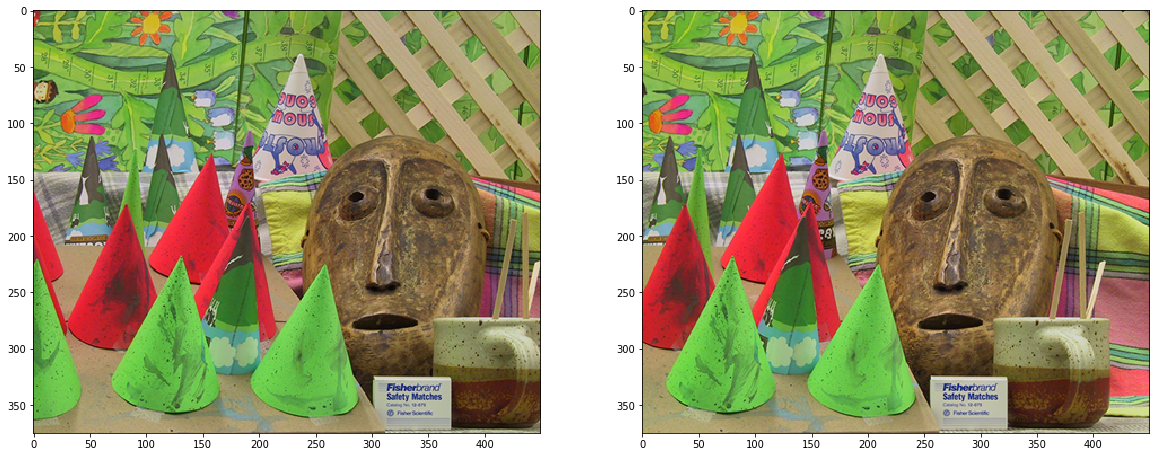

In [3]:
# Read in the images
imgL = io.imread('im2.png', as_gray=True)
imgR = io.imread('im6.png', as_gray=True)

# Show rectified images
fig = plt.figure(figsize=(20,30))
plt.subplot(1,2,1).imshow(io.imread('im2.png'))
plt.subplot(1,2,2).imshow(io.imread('im6.png'))

In [5]:
# Initialize the variables used
pix_range = 60 #depth levels
V = np.zeros((pix_range,pix_range))
D = np.zeros((imgL.shape[0], imgL.shape[1], pix_range))

# Loop through each pixel in image 1
for i in trange(imgL.shape[0]):
    for j in range(imgL.shape[1]):
        for k in range(pix_range):
            original = np.array(imgL[i][j])
            
            # if pixel is too far left, we will just use the pixel on image 2 to the right
            if j-k <=0:
                D[i][j][k] = abs(original-np.array(imgR[i][j+k]))
                
            # if pixel is too far right, we will just use the pixel on image 2 to the left
            elif j+k>=imgL.shape[1]:
                D[i][j][k] = abs(original-np.array(imgR[i][j-k]))
                
            # compare the pixels on left and right and use the most similar pixel
            else:
                D[i][j][k]= min(abs(original-np.array(imgR[i][j-k])), abs(original-np.array(imgR[i][j+k])))
                
D = np.array(D)*50 #enhance the difference

# Calculate V with a difference in disparity
V = np.zeros((pix_range,pix_range))
for i in range(D.shape[2]):
    V[i] = [abs(j-i) for j in range(D.shape[2])] 

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:59<00:00,  6.85it/s]


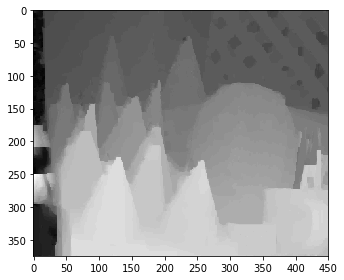

In [6]:
# Calculate and plot the resulting depth image
labels = aexpansion_grid(D,V)
io.imshow(labels/labels.max())

## Depth from Stereo

Estimating depth map with similar methods but with unrectified image (trace along calculated gradients rather than horizontal axis)

### 1. Calculate variables from camera matrices

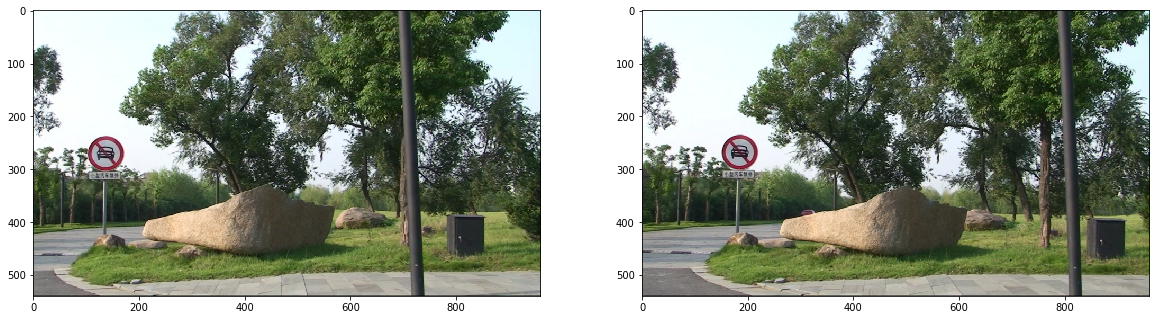

In [5]:
# Read in the images
img1 = io.imread('test00.jpg', as_gray=True)
img2 = io.imread('test09.jpg', as_gray=True)

# Show rectified images
fig = plt.figure(figsize=(20,30))
plt.subplot(1,2,1).imshow(io.imread('test00.jpg'))
plt.subplot(1,2,2).imshow(io.imread('test09.jpg'))

In [3]:
# Retrieve the x infinity point for each input
def get_xinf(x):
    return np.dot(np.dot(np.dot(np.dot(k2, r2), r1.T), np.linalg.inv(k1)), x)

# Calculate the gradient of the epipole line for each input
def get_grad(x):
    '''
        Function calculates the gradient of the line by using two points found on img2's epipole line for some input
        Input:
            x: coordinate point from img1
        Output: 
            1. gradient of epipole line
            2,3. points on the epipole line on the far ends of the axis
    '''
    x_inf = get_xinf(x)
    
    # Get the coordinates for either x or y = 0
    dx = -x_inf[1]/e2[1] #lets 2nd index be 0
    dy = -x_inf[0]/e2[0] #lets 1st index be 0
    if (x_inf[0] + dx*e2[0] < 0) or (x_inf[0] + dx*e2[0] >= img1.shape[1]): d_start = dy
    else: d_start = dx

    # Get the coordinates for either x or y = max of axis
    dx = (img1.shape[0]-x_inf[1])/e2[1] #lets 2nd index be 0
    dy = (img1.shape[1]-x_inf[0])/e2[0] #lets 1st index be 0
    if (x_inf[0] + dx*e2[0] < 0) or (x_inf[0] + dx*e2[0] >= img1.shape[1]): d_end = dy
    else: d_end = dx

    # Use coordinates found to get gradient of epipole line
    x_start = (x_inf + d_start*e2)[0]
    y_start = (x_inf + d_start*e2)[1]
    x_end = (x_inf + d_end*e2)[0]
    y_end = (x_inf + d_end*e2)[1]
    
    return (y_start - y_end)/(x_end - x_start), x_inf + d_start*e2, x_inf + d_end*e2

In [4]:
# Define camera matrices
k1 = np.array([[1221.2270770, 0.0000000, 479.5000000],
      [0.0000000, 1221.2270770, 269.5000000],
      [0.0000000, 0.0000000, 1.0000000]])
r1 = np.identity(3)
t1 = np.array([0, 0, 0])

k2 = np.array([[1221.2270770, 0.0000000, 479.5000000],
      [0.0000000, 1221.2270770, 269.5000000],
      [0.0000000, 0.0000000,1.0000000]])
r2 = np.array([[0.9998813487,0.0148994942, 0.0039106989],
      [-0.0148907594, 0.9998865876, -0.0022532664],
      [-0.0039438279, 0.0021947658, 0.9999898146]])
t2 =  np.array([-9.9909793759, 0.2451742154, 0.1650832670])

# Calculate c,e using camera matrices
c2 = np.dot(-np.linalg.inv(r2), t2)
e2 = np.dot(np.dot(k2, r2), -c2)

### 2. Verify calculated gradient of epipole line through visual comparison

In [10]:
# Verify for street sign [120,280]
get_grad([120,280,1])

(0.028369953455857317,
 array([  0.        , 286.47695365,   1.00287925]),
 array([960.        , 259.24179833,   0.98980561]))

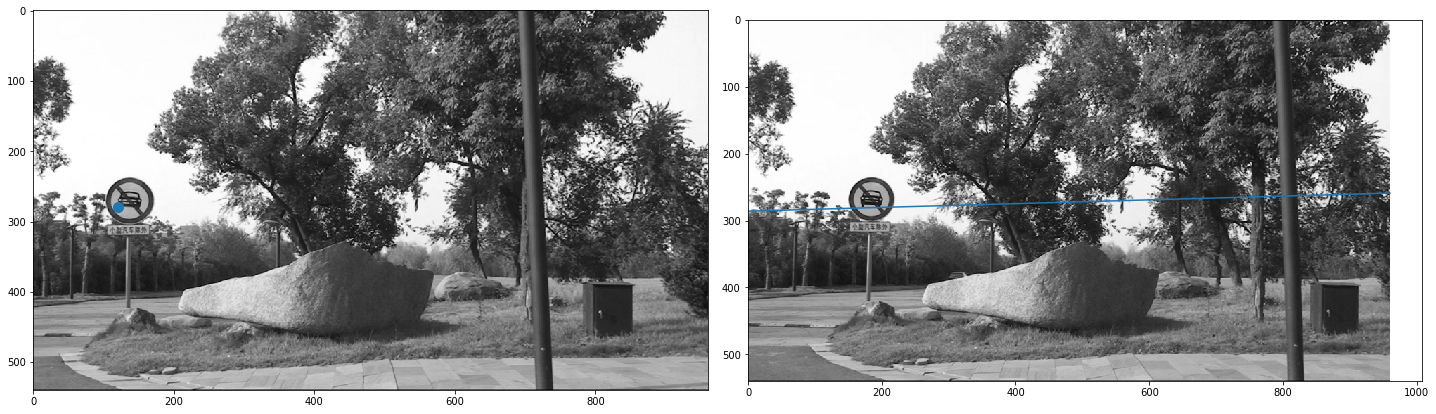

In [11]:
fig = plt.figure(figsize=(20,30))

# img1 shows the point in focus
ax1 = plt.subplot(1,2,1)
io.imshow(img1)
plt.scatter([120],[280], s=100)

# img2 shows the line derived from the point
ax2 = plt.subplot(1,2,2)
io.imshow(img2)
plt.plot([0, 960],[286,259])

In [12]:
# Verify for rock [400,400]
get_grad([400,400,1])

(0.028369953455857317,
 array([  0.        , 410.09236333,   1.00602322]),
 array([960.        , 382.85720801,   0.99294958]))

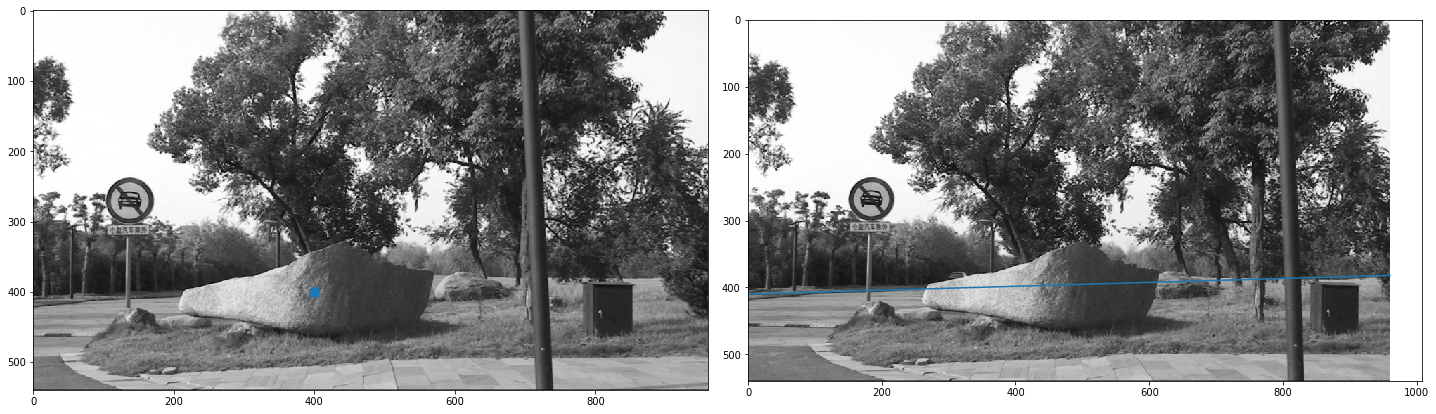

In [13]:
fig = plt.figure(figsize=(20,30))

# img1 shows point in focus
ax1 = plt.subplot(1,2,1)
io.imshow(img1)
plt.scatter([400],[400], s=100)

# img2 shows line derived from epipole line
ax2 = plt.subplot(1,2,2)
io.imshow(img2)
plt.plot([0, 960],[410,382])

#### Conclusion: Since inverse of gradient is around 35, for every 35 pixels travelled to the right, we rise up by 1 pixel

### 3. Calculate depth

In [5]:
# Get the corresponding coordinates of image 1 on image 2
def get_img2_position(x):
    x_inf = get_xinf(x)
    d = (x[0]-x_inf[0])/e2[0] #lets 1st index be x[0]
    return x_inf + d*e2

In [6]:
# Define variables
gradient = 35
pix_range = 125
skip = round(img1.shape[1]/gradient)+1 #dropping row 0 to skip, skip to end to avoid line extending above/below picture

V = np.zeros((pix_range, pix_range))
D = np.zeros((img1.shape[0]-(2*skip), img1.shape[1], pix_range))
    
# Calculate D by looping through all pixels on image 1
for i in trange(skip, img1.shape[0]-skip):
    for j in range(img1.shape[1]):
        original = np.array(img1[i][j])
        for k in range(pix_range):
            
            # get x,y coordinates of the equivalentp pixel on img2
            x2 = get_img2_position([j,i,1]) # [j,i,1] is position of img[i][j] on the matrix
            i2,j2 = int(round(x2[1])), int(round(x2[0]))

            # Always look for pixel to the right of the line, and if out of bounds, set arbitrary large disparity (10)
            if (j2+k) >= img1.shape[1]:
                D[i-skip][j][k] = 10
            else:
                D[i-skip][j][k] = abs(original-np.array(img2[i2+(k//gradient)][j2+k]))
               

100%|████████████████████████████████████████████████████████████████████████████████| 484/484 [21:28<00:00,  2.63s/it]


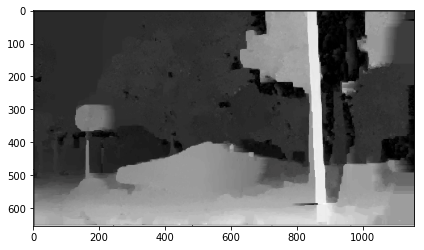

In [7]:
st = time.time()

# Defining V and D
V = np.zeros((D.shape[2], D.shape[2]))
for i in range(D.shape[2]):
    V[i] = [abs(j-i)/7 for j in range(D.shape[2])] 
De = D*80

# Running maxflow function
labels = aexpansion_grid(De,V)
end = time.time()

# Show image
print(end-st)
plt.figure(figsize=(10,20))
io.imshow(labels/labels.max())

winsound.MessageBeep()